In [8]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbMetricsLogger
import resnets as rn

In [9]:
wandb.login()

True

## Set hyperparameters

In [10]:
using_dataset = "data_relabeled_balanced_1x"

train_path = f"facial-affect-data-relabeled/{using_dataset}/train"
test_path = f"facial-affect-data-relabeled/{using_dataset}/test"

image_size = 96
channels = 3
color_mode = "rgb"
validation_split = 0.2
seed = 27

config = {
    "batch_size": 64,
    "epochs": 100,
    "learning_rate": 0.000001,
    "early_stop_patience": 10,
    "normalize": True
}

## Run the following block on Kaggle only!

In [11]:
train_path = "/kaggle/input/" + train_path
test_path = "/kaggle/input/" + test_path

## Get class names

In [12]:
classes = next(os.walk(train_path))[1]
print(classes)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


## Create training, validation and test datasets

In [13]:
train, validation = image_dataset_from_directory(
    directory=train_path,
    validation_split=validation_split,
    subset="both",
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    seed=seed,
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    shuffle=False
)

Found 29217 files belonging to 8 classes.
Using 23374 files for training.
Using 5843 files for validation.
Found 7297 files belonging to 8 classes.


## Training on ResNet-34

In [14]:
wandb.init(config=config, project='resnet-final-model')

optimizer = Adam(
    learning_rate=config["learning_rate"]
)
loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model = rn.ResNet34(
    (image_size, image_size, channels),
    normalize=config["normalize"],
    include_top=False,
    flatten=True,
    dropout_rate=0.2
)

top = Dense(4096, activation="relu")(model.output)
top = Dropout(0.5)(top)
top = Dense(4096, activation="relu")(top)
top = Dropout(0.5)(top)
top = Dense(len(classes), activation="softmax")(top)

model = Model(inputs=model.input, outputs=top)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

callbacks = [
    early_stopping,
    WandbMetricsLogger()
]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)

Epoch 1/100
366/366 [==============================] - 59s 84ms/step - loss: 3.8290 - sparse_categorical_accuracy: 0.1276 - val_loss: 2.1834 - val_sparse_categorical_accuracy: 0.1405
Epoch 2/100
366/366 [==============================] - 30s 81ms/step - loss: 3.4180 - sparse_categorical_accuracy: 0.1325 - val_loss: 2.1822 - val_sparse_categorical_accuracy: 0.1551
Epoch 3/100
366/366 [==============================] - 30s 80ms/step - loss: 3.1731 - sparse_categorical_accuracy: 0.1369 - val_loss: 2.1451 - val_sparse_categorical_accuracy: 0.1619
Epoch 4/100
366/366 [==============================] - 29s 80ms/step - loss: 2.9617 - sparse_categorical_accuracy: 0.1401 - val_loss: 2.1038 - val_sparse_categorical_accuracy: 0.1749
Epoch 5/100
366/366 [==============================] - 30s 81ms/step - loss: 2.8144 - sparse_categorical_accuracy: 0.1394 - val_loss: 2.0879 - val_sparse_categorical_accuracy: 0.1783
Epoch 6/100
366/366 [==============================] - 30s 80ms/step - loss: 2.6908 -

In [15]:
wandb.finish()

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'



epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/val_loss,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇████████
epoch/epoch,99
epoch/learning_rate,0.0
epoch/loss,1.39256
epoch/sparse_categorical_accuracy,0.48062
epoch/val_loss,1.78352


## Evaluation

115/115 [==============================] - 8s 68ms/step - loss: 1.7661 - sparse_categorical_accuracy: 0.3325


[1.7660691738128662, 0.33246541023254395]

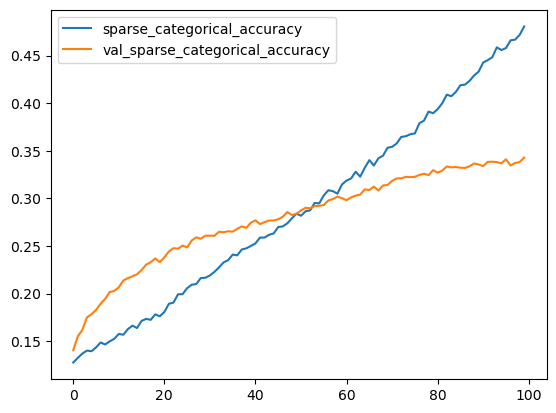

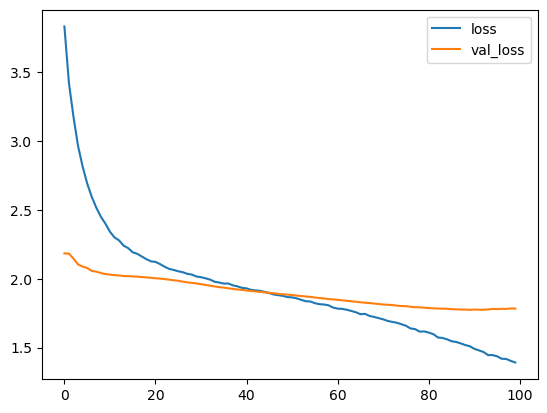

In [16]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

model.evaluate(test)